### Notebook for testing model functions with input data and examining output

To do:
* hydrology model uses a sustainable flow parameter, as in INCA. This is a fudge and needs replacing
* Add saturation excess to quick flow
* See notes in Word doc on the sediment equations, together with a to do list specifically relating to suspended sediment
* As sediment equations don't use stream velocity, the only thing it's used in at the moment is to calculate the reach time constant. Excessive, as it's two parameters? Can't re-calculate using v=Q/A, as it becomes circular when you try to work out T and V. Other options to reduce the number of parameters?

14/12/2015:
Making progress with adding in land use-varying processes. Tomorrow: check what I've done so far. Realistic results? Play with parameters to make sure soil water is contributing to stream TDP in the right way.
Then change the sediment and PP-related processes so they vary by land use.

15/12/2015:
Checked soil water and TDP - some oddness with Qs from A vs S - need to keep an eye that they're the same when they're parameterised the same. Otherwise looks mostly good. Quick flow seems to be working right too.
* What to do about quick flow? Should it vary by land use type? And if so, how? No quick flow apart from from agricultural land? Or quick flow from both, but more from agricultural land?
* Investigate whether having quick flow separated between agricultural and semi-natural land means that there's no longer the need for them to have separate land use classes.
* Need to add in another land use class - new semi-natural or new agricultural. Needs to have a hybrid of parameter values from the other two, plus one additional new parameter value if it's new semi-natural (net P inputs)

Tomorrow: vary Mland_i by land use, and try to get the new land use class added in too, or at least planned.

In [1]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
from scipy import optimize
import numpy as np, pandas as pd
from scipy.integrate import odeint
from scipy.stats import norm
sn.set_context('notebook')

In [2]:
# Unit conversions
# Throughout, A_catch has units of km2
def UC_Q(Q_mmd, A_catch):
    """Convert discharge from units of mm/day to m3/day"""
    Q_m3d = Q_mmd*1000*A_catch
    return Q_m3d

def UC_Qinv(Q_m3s, A_catch):
    """Convert discharge from units of m3/s to mm/day"""
    Q_mmd = Q_m3s * 86400/(1000*A_catch)
    return Q_mmd

def UC_C(C_kgmm, A_catch):
    """Convert concentration from units of kg/mm to mg/l
    Divide answer by 10**6 to convert from mg/mm to mg/l"""
    C_mgl = C_kgmm/A_catch
    return C_mgl

def UC_Cinv(C_mgl, A_catch):
    """Convert concentration from units of mg/l to kg/mm"""
    C_kgmm = C_mgl*A_catch
    return C_kgmm
    
def UC_V(V_mm, A_catch, outUnits):
    """Convert volume from mm to m^3 or to litres. outUnits 'm3' or 'l'"""
    factorDict = {'m3':10**3, 'l':10**6}
    V = V_mm * factorDict[outUnits] * A_catch
    return V

In [3]:
# SNOW ACCUMULATION AND MELT

# Source for priors for DDF: http://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=17753.wba
# To Do:
# (1) Add options for how temperature is assumed to vary through the day. At the moment, assume average
# temperature throughout the day. In future, could look at triangular or sinuosoidal variations throughout
# the day, to get a more accurate portrayal of the degree-days above the threshold.
# Also assumes no melting below 0 deg C.

# (2) Consider setting ET to 0 when D_snow > 0.

def hydrol_inputs(D_snow_0, f_DDSM, met_df):
    """Function to calculate snow accumulation and melt.
    Calculates total hydrological input to soil box as precipitation as rain + snowmelt
    
    D_snow_0: Initial snow depth (mm)
    f_DDSM: Degree-day factor for snow melt (mm/degree-day deg C)
    met_df: Dataframe of met data with cols T_air, PET, Pptn
    
    Returns met_df with additional columns [P_snow, P_rain, P_melt, D_snow_start
    D_snow_end, P]
    
    Of these, P is the hydrological input to the soil store
    """

    # Calculate precipitation falling as snow and add to met_df
    met_df.loc[:,'P_snow'] = met_df['Pptn'].ix[met_df['T_air']<0]
    met_df['P_snow'].fillna(0, inplace=True)

    # Calculate precipitation falling as rain and add to met_df
    met_df['P_rain'] = met_df['Pptn'] - met_df['P_snow']

    # Calculate daily snow melt, if unlimited snow pack depth to melt (mm/day)
    met_df['P_melt'] = f_DDSM*(met_df['T_air']-0)
    met_df['P_melt'][met_df['P_melt']<0]=0  # Set negative values to 0

    # Calculate snow pack depth
    met_df['D_snow_start'] = np.nan
    met_df['D_snow_end'] = np.nan

    # First time-step manually, to take initial condition into account
    met_df.ix[0,'D_snow_start'] = D_snow_0 #Assign start snow depth to first row
    met_df.ix[0,'P_melt'] = np.minimum(met_df.ix[0,'P_melt'],met_df.ix[0,'D_snow_start'])
    met_df.ix[0,'D_snow_end'] = met_df.ix[0,'D_snow_start']+met_df.ix[0,'P_snow']-met_df.ix[0,'P_melt']

    # Calculate for subsequent days
    for idx in range (1,len(met_df)):
        met_df.ix[idx,'D_snow_start'] = met_df.ix[idx-1,'D_snow_end']
        met_df.ix[idx,'P_melt'] = np.minimum(met_df.ix[idx,'P_melt'],met_df.ix[idx,'D_snow_start'])
        met_df.ix[idx,'D_snow_end'] = met_df.ix[idx,'D_snow_start']+met_df.ix[idx,'P_snow']-met_df.ix[idx,'P_melt']

    # Hydrological input to soil box
    met_df.loc[:,'P'] = met_df['P_rain'] + met_df['P_melt']
    
    return met_df

In [4]:
def P_model_LU(met_df, p, p_LU, dynamic_dict, run_mode, step_len=1):
    """
    Third version of hydrology, sediment and phosphorus model, with processes varying by land use,
    including the ability to simulate a newly converted land use class (semi-natural to agricultural,
    or agricultural to semi-natural)
    Inputs:
        met_df         Dataframe containing columns 'P', the precipitation+snowmelt input to
                       the soil box, and 'PET' (units mm)

        p              Series of parameter values which don't vary by land use (index: param name)
        
        p_LU           Dataframe of parameter values which vary by land use
                       Index: parameter name
                       Columns: 'A', 'S', 'IG' (agricultural, semi-natural, improved grassland)
                       IG only has values for parameter 'E_land' (soil erodibility), in which case
                       value in 'A' column is for arable land

        dynamic_dict   Dictionary of options controlling whether inputs/variables are calculated
                       dynamically or kept constant.
                       Dictionary keys: 'Dynamic_EPC0', 'Dynamic_effluent_inputs',
                       'Dynamic_terrestrialP_inputs', 'Dynamic_GW_TDP'. Set to 'y' or 'n'.
                       **NB only the first is implemented in the model at the moment***

        run_mode       'cal' or 'val'. Determines whether the soil sorption coefficient, Kf,
                       is calculated (calibration period) or read in as a parameter (validation period)

        step_len       Length of each step in the input dataset (days). Default=1

    Returns a two-element tuple (df, Kf):
    1) A dataframe with column headings:
        Vs: Soil water volume (mm), Qs: Soil water flow (mm/d)
        Vg: Groundwater volume (mm), Qg: Groundwater flow (mm/d)
        Qq: Quick flow (mm/d)
        Vr: Reach volume (mm), Qr: Reach discharge (mm/d), Dr: Daily average reach discharge (mm/d)
        Mland: Sediment mass delivered ot the stream (kg/d), Msus: Reach suspended sediment mass
        P_labile: labile soil P mass (kg), EPC0_kgmm: Soil EPC0 (kg/mm), TDPs: Soil water TDP mass (kg)
        TDPr: Instream TDP mass (kg), PPr: Instream PP mass (kg)
    2) Kf, the soil adsorption coefficient (units mm/kg Soil). #Units (mgP/kgSoil)(mm/kgP).
       Multiply by: 10^-6 for (mm/kgSoil), by A_catch*10^6 for (l/kgSoil)
    """
    
    # #########################################################################################
    # Define the ODE system
    def ode_f(y, t, ode_params):
        """
        Define ODE system
        Inputs:
            y: list of variables expressed as dy/dx. The value of y is determined for the end of the time step
            t: array of time points of interest
            params: tuple of input values & model parameter values
        """
        
        # Unpack params. Params that vary by LU are series, with indices ['A','S','IG'],
        # LU-varying params: f_TDPr (fraction of land use for TDP input to reach calc), T_s,P_netInput,EPC0,Mland_i
        (P, E, Qq_i, Mland_i, f_A, f_Ar, f_IG, f_S, f_NC_A, f_NC_Ar, f_NC_IG, f_NC_S, NC_type,
         f_IExcess, alpha, beta, T_s, T_g, fc, L_reach, S_reach, A_catch, a_Q, b_Q, E_Q, k_EQ,
        P_netInput, EPC0_A, EPC0_NC, Kf, Msoil, TDPeff, TDPg, E_PP, PPeff, P_inactive) = ode_params
        
        # Unpack initial conditions for this time step 
        # Hydrology
        VsA_i = y[0] # Agricultural soil water volume (mm)
        QsA_i = y[1] # Agricultural soil water flow (mm/day)
        VsS_i = y[2] # Semi-natural soil water volume (mm)
        QsS_i = y[3] # Semi-natural soil water flow (mm/day)
        Vg_i = y[4]  # Groundwater volume (mm)
        Qg_i = y[5]  # Groundwater discharge (mm/day)
        Vr_i = y[6]  # Reach volume (mm)
        Qr_i = y[7]  # Reach discharge (mm/day)
        #(Qr_av_i would be y[8] here, but it's 0 at the start of every time step)
        # Sediment
        Msus_i = y[9]  # Mass of suspended sediment in the stream reach (kg)
        # (Msus_out_i would be y[10], but it's 0 at the start of every time step)
        # Phosphorus
        PlabA_i = y[11] # Mass of labile P in agricultural soil (kg)
        PlabNC_i = y[12] # Mass of labile P in newly converted land class (kg)
        TDPsA_i = y[13] # Mass of TDP in agricultural soil water (kg)
        TDPsNC_i = y[14] # Mass of TDP in newly converted land class (kg)
        TDPr_i = y[15] # Mass of total dissolved P in stream reach (kg)
        # (TDPr_out_i would be y[16], but it's 0 at the start of every time step)
        PPr_i = y[17]  # Mass of particulate P in stream reach (kg)
        # (PPr_out_i would be y[18], but it's 0 at the start of every time step)
        # Soil water vol & flow for newly converted land class
        if NC_type == 'A':  # If semi-natural converted to arable, assume has arable hydrol
            VsNC_i = VsA_i
            QsNC_i = QsA_i
        else:
            VsNC_i = VsS_i  # If arable converted to SN, assume has semi-natural hydrol
            QsNC_i = QsS_i
    
        # HYDROLOGY
        
        # Soil hydrology equations (units mm or mm/day): Agricultural land
        dQsA_dV = ((((VsA_i - fc)*np.exp(fc - VsA_i))/(T_s['A']*((np.exp(fc-VsA_i) + 1)**2)))
                    +(1/(T_s['A']*(np.exp(fc-VsA_i) + 1))))
        dVsA_dt = P*(1-f_IExcess) - alpha*E*(1 - np.exp(-0.02*VsA_i)) - QsA_i
        dQsA_dt = dQsA_dV*dVsA_dt
        
        # Soil hydrology equations (units mm or mm/day): Semi-natural/other land
        dQsS_dV = ((((VsS_i - fc)*np.exp(fc - VsS_i))/(T_s['S']*((np.exp(fc-VsS_i) + 1)**2)))
                    +(1/(T_s['S']*(np.exp(fc-VsS_i) + 1))))
        dVsS_dt = P*(1-f_IExcess) - alpha*E*(1 - np.exp(-0.02*VsS_i)) - QsS_i
        dQsS_dt = dQsS_dV*dVsS_dt
        
        # Groundwater equations (units mm or mm/day)
        dQg_dt = (beta*(f_A*QsA_i + f_S*QsS_i) - Qg_i)/T_g
        dVg_dt = beta*(f_A*QsA_i + f_S*QsS_i) - Qg_i
        
        # Instream equations (units mm or mm/day)
        dQr_dt = (((Qq_i + (1-beta)*(f_A*QsA_i + f_S*QsS_i) + Qg_i) - Qr_i)
                  *a_Q*(Qr_i**b_Q)*(8.64*10**7)/((1-b_Q)*(L_reach*1000))) #U/L=1/T. Units (m/s)(s/d)(mm/m)/m(mm/m) 
        dVr_dt = Qq_i + (1-beta)*(f_A*QsA_i + f_S*QsS_i) + Qg_i - Qr_i
        dQr_av_dt = Qr_i  # Daily mean flow
        
        # SEDIMENT
        # Instream suspended sediment (kg; change in kg/day)
        dMsus_dt = (f_Ar*Mland_i['A'] + f_IG*Mland_i['IG'] + f_S* Mland_i['S']     # Delivery from the land (kg/day)
                   + E_Q*S_reach*(Qr_i**k_EQ)                        # Entrainment from the stream bed (kg/d)
                   - (Msus_i/Vr_i)*Qr_i)                             # Outflow from the reach;(kg/mm)*(mm/day)
        
        dMsus_out_dt = Qr_i*Msus_i/Vr_i  # Daily flux of SS
        
        # PHOSPHORUS
        
        # Agricultural soil labile phosphorus mass (kg) (two alternative formulations; give same results)
        # Assume semi-natural land has no labile soil P
        dPlabA_dt = Kf*Msoil*((TDPsA_i/VsA_i)-EPC0_A)  # Net sorption
        # dPlabA_dt = (PlabA_i/EPC0_A)*((TDPsA_i/VsA_i)-EPC0_A)
        
        # Newly-conveted soil labile P mass (kg)
        dPlabNC_dt = Kf*Msoil*((TDPsNC_i/VsNC_i)-EPC0_NC)
        
        # Change in dissolved P mass in agricultural soil water (kg/day)
        # Assume semi-natural land has no dissolved soil water P
        dTDPsA_dt = ((P_netInput['A']*100*A_catch/365)      # Net inputs (fert + manure - uptake) (kg/ha/yr)
                   - Kf*Msoil*((TDPsA_i/VsA_i)-EPC0_A)      # Net sorpn (kg/day)
                                                            # Alternative: (PlabA_i/EPC0_A)*((TDPsA_i/VsA_i)-EPC0_A) 
                   - (QsA_i*TDPsA_i/VsA_i)                  # Outflow via soil water flow (kg/day)
                   - (Qq_i*TDPsA_i/VsA_i))                  # Outflow via quick flow (kg/day)
        
        # And in newly converted land class soil water
        dTDPsNC_dt = ((P_netInput['NC']*100*A_catch/365)    # Net inputs (fert + manure - uptake) (kg/ha/yr)
                   - Kf*Msoil*((TDPsNC_i/VsNC_i)-EPC0_NC)   # Net sorpn (kg/day)
                   - (QsNC_i*TDPsNC_i/VsNC_i)               # Outflow via soil water flow (kg/day)
                   - (Qq_i*TDPsNC_i/VsNC_i))                # Outflow via quick flow (kg/day)
        
        # Change in in-stream TDP mass (kg/d).
        # Semi-natural inputs not specified as assume 0 for soil water & quick flow
        dTDPr_dt = ((1-beta)*f_A*QsA_i*(TDPsA_i/VsA_i)  # Soil water input, old agri land. Units: (mm/d)(kg/mm)
                   + (1-beta)*f_NC_A*QsNC_i*(TDPsNC_i/VsNC_i)  # Soil water input, newly converted agri land (may be 0)
                   + (1-beta)*f_NC_S*QsNC_i*(TDPsNC_i/VsNC_i)  # Soil water input, newly converted SN land (may be 0)
                   + f_A*Qq_i*(TDPsA_i/VsA_i)           # Quick flow input, old agri land. Units: (mm/d)(kg/mm)
                   + f_NC_A*Qq_i*(TDPsNC_i/VsNC_i)      # Quick flow inputs, newly-converted agri (may be 0)
                   + f_NC_S*Qq_i*(TDPsNC_i/VsNC_i)      # Quick flow inputs, newly-converted SN (may be 0)
                   + Qg_i*UC_Cinv(TDPg,A_catch)         # Groundwater input. Units: (mm/d)(kg/mm)
                   + TDPeff                             # Effluent input (kg/day)
                   - Qr_i*(TDPr_i/Vr_i))                # Outflow from the reach. Units: (mm/d)(kg/mm)
        
        dTDPr_out_dt = Qr_i*TDPr_i/Vr_i  # Daily TDP flux out of reach. Units: (mm/d)(kg/mm)=kg/d
        
        # Change in in-stream PP mass (kg/d)
        dPPr_dt = (E_PP *
                   (f_Ar*Mland_i['A']*(PlabA_i+P_inactive)/Msoil         # From old arable land
                   + f_IG*Mland_i['IG']*(PlabA_i+P_inactive)/Msoil       # From old improved grassland
                   + f_S*Mland_i['S']*P_inactive/Msoil)                  # From semi-natural land
                   + f_NC_Ar*Mland_i['A']*(PlabNC_i+P_inactive)/Msoil    # From newly-converted arable
                   + f_NC_IG*Mland_i['IG']*(PlabNC_i+P_inactive)/Msoil   # From newly-converted IG
                   + f_NC_S*Mland_i['S']*(PlabNC_i+P_inactive)/Msoil     # From newly-converted semi-natural
                   + (E_Q*S_reach*(Qr_i**k_EQ))*E_PP*(f_A*(PlabA_i+P_inactive)+f_S*P_inactive)/Msoil  # Entrained                + PPeff                      # Effluent input (kg/day)
                   - Qr_i*(PPr_i/Vr_i))                                  # Outflow from reach. Units: (mm/d)(kg/mm)
        
        dPPr_out_dt = Qr_i*PPr_i/Vr_i  # Daily mean flux
        
        # Add results of equations to an array
        res = np.array([dVsA_dt, dQsA_dt, dVsS_dt, dQsS_dt, dVg_dt, dQg_dt, dVr_dt, dQr_dt, dQr_av_dt,
                        dMsus_dt, dMsus_out_dt, dPlabA_dt, dPlabNC_dt, dTDPsA_dt, dTDPsNC_dt,
                        dTDPr_dt, dTDPr_out_dt, dPPr_dt, dPPr_out_dt])
        return res
    
    # ###########################################################################################
    # --------------------------------------------------------------------------------------------

    # INITIAL CONDITIONS AND DERIVED PARAMETERS
    # Unpack user-supplied initial conditions and calculate other initial conditions which are not modified
    # during looping over met data
    
    # 1) Hydrology
    VsA0 = p['fc']   # Initial soil volume (mm). Assume it's at field capacity.
    VsS0 = VsA0      # Initial soil vol, semi-natural land (mm). Assume same as agricultural for now!!
    Qg0 = p['Qg0_init']      # Initial groundwater flow (mm/d)
    Qr0 = UC_Qinv(p['Qr0_init'], p['A_catch'])  # Convert units of initial reach Q from m3/s to mm/day
    
    # 2) Initial instream suspended sediment mass (kg). Assume it's 0 kg
    Msus0 = 0.0
    
    # 3) Terrestrial P
    # Calculate initial conditions and convert input param units where necessary
    p['Msoil'] = p['Msoil_m2'] * 10**6 * p['A_catch'] # Soil mass (kg). Units: kgSoil/m2 * m2/km2 * km2
    # Inactive soil P mass (kg). Assume equals semi-natural total soil P mass for all LU classes
    p['P_inactive'] = 10**-6*p_LU['S']['SoilPconc']*p['Msoil']
    
    # Varying by LU (intensive agricultural or semi-natural)
    for LU in ['A','S']:
        # Convert units of EPC0 from mg/l to kg/mm to give initial EPC0
        p_LU.ix['EPC0_0',LU] = UC_Cinv(p_LU[LU]['EPC0_init_mgl'], p['A_catch'])
        # Initial labile P. Units: kgP/mgP * mgP/kgSoil * kgSoil. Assume Plab0 = 0 for semi-natural
        p_LU.ix['Plab0',LU] = 10**-6*(p_LU[LU]['SoilPconc']-p_LU['S']['SoilPconc']) * p['Msoil']  
        # Initial soil water TDP mass (kg); Units: (kg/mm)*mm
        p_LU.ix['TDPs0',LU] = p_LU[LU]['EPC0_0'] * (p['f_A']*VsA0+p['f_S']*VsS0)
    
    # Set initial agricultural labile P and soil TDP masses as variables to be updated during looping
    # (assume semi-natural remain at 0 for both)
    Plab0_A, TDPs0_A = p_LU.ix['Plab0','A'], p_LU.ix['TDPs0','A']
    # Initial labile P and soil TDP mass on newly converted land use class
    if p['NC_type']=='S':
        Plab0_NC = Plab0_A  # New class is semi-natural, from arable, therefore start with arable labile P
        TDPs0_NC = TDPs0_A
    else:
        Plab0_NC = 0.0        # New class is arable, converted from SN, therefore start with no labile P
        TDPs0_NC = p_LU.ix['TDPs0','S']
    
    # Set the value for Kf, the adsorption coefficient (mm/kg soil)
    if run_mode == 'cal':
        # If the calibration period, calculate. Assume SN has EPC0=0, PlabConc =0
        Kf = 10**-6*(p_LU['A']['SoilPconc']-p_LU['S']['SoilPconc'])/p_LU['A']['EPC0_0']  # (kg/mg)(mg/kgSoil)(mm/kg)
    else:
        # If not the calibration period, read Kf in from the series of param values
        Kf = p['Kf']

    # 4) Initial instream TDP and PP masses (kg; assume both equal 0.0)
    TDPr0 = 0.0
    PPr0 = 0.0
    
    # --------------------------------------------------------------------------------------------    
    # SETUP ADMIN FOR LOOPING OVER TIME STEPS
    # Time points to evaluate ODEs at (we're only interested in the start and end of each step)
    ti = [0, step_len]
    # Lists to store output
    output_ODEs = []  # From ode_f function
    output_nonODE = []  # Will include: Qq, Mland

    # --------------------------------------------------------------------------------------------
    # START LOOP OVER MET DATA
    for idx in range(len(met_df)):

        # Get precipitation and evapotranspiration for this day
        P = met_df.ix[idx, 'P']
        E = met_df.ix[idx, 'PET']
        
        # Calculate infiltration excess (mm/(day * catchment area))
        Qq_i = p['f_IExcess']*P
        
        # Calculate terrestrial erosion and delivery to the stream, Mland (kg/day)
        # NB this is the flux assuming the land use covered the whole catchment. Divide by catchment
        # area to get areal flux to e.g. compare to literature values
        Mland_i = pd.Series(3*[np.NaN],['A','S','IG'])
        for LU in ['A','S','IG']:
            Mland_i[LU] = p_LU[LU]['E_land']*(Qq_i**p['k_Eland']) #Units: (kg/mm)*(mm/day)
        
        # Calculate dynamic EPC0 as a function of labile P mass
        if dynamic_dict['Dynamic_EPC0'] == 'y':
            # Agricultural EPC0
            EPC0_A_i = Plab0_A/(Kf*p['Msoil']) # First timestep this equals EPC0_0
            # EPC0 on newly-converted land
            EPC0_NC_i = Plab0_NC/(Kf*p['Msoil'])
        # Or, have a constant EPC0 throughout the model run
        else:
            EPC0_A_i = p_LU['A']['EPC0_0']
            # New semi-natural land has agricultural EPC0; new agricultural has SN EPC0
            # NB, there's no point in having a new land class with constant EPC0...
            if p['NC_type'] == 'S':
                EPC0_NC_i = p_LU['A']['EPC0_0']
            else:
                EPC0_NC_i = p_LU['S']['EPC0_0']
        
        # Append to non ODE results
        output_nonODE_i = [Qq_i, Mland_i['A'],Mland_i['IG'],Mland_i['S'], EPC0_A_i, EPC0_NC_i]
        output_nonODE.append(output_nonODE_i)

        # Calculate additional initial conditions from user-input initial conditions/ODE solver output
        QsA0 = (VsA0 - p['fc'])/(p_LU['A']['T_s']*(1 + np.exp(p['fc'] - VsA0))) # Soil flow (mm/d)
        QsS0 = (VsS0 - p['fc'])/(p_LU['S']['T_s']*(1 + np.exp(p['fc'] - VsS0)))
        Vg0 = Qg0 *p['T_g'] # groundwater vol (mm)
        Tr0 = (1000*p['L_reach'])/(p['a_Q']*(Qr0**p['b_Q'])*(8.64*10**7)) #Reach time constant (days); T=L/aQ^b
        Vr0 = Qr0*Tr0 # Reach volume (V=QT) (mm)

        # Vector of initial conditions for start of time step (assume 0 for initial Qr_av, Msus_av, TDPr_av
        # and PPr_av, the daily fluxes of water or mass
        y0 = [VsA0, QsA0, VsS0, QsS0, Vg0, Qg0, Vr0, Qr0, 0.0, Msus0, 0.0, Plab0_A, Plab0_NC,
              TDPs0_A, TDPs0_NC, TDPr0, 0.0, PPr0, 0.0]

        # Today's rainfall, ET & model parameters for input to solver. NB the order must be the same as the
        # order in which they are unpacked within the odeint function
        ode_params = [P, E, Qq_i, Mland_i,
                      p['f_A'],p['f_Ar'],p['f_IG'],p['f_S'],
                      p['f_NC_A'],p['f_NC_Ar'],p['f_NC_IG'],p['f_NC_S'],p['NC_type'],
                      p['f_IExcess'],p['alpha'], p['beta'],
                      p_LU.ix['T_s'], p['T_g'], p['fc'],
                      p['L_reach'], p['S_reach'], p['A_catch'],
                      p['a_Q'], p['b_Q'],
                      p['E_Q'], p['k_EQ'],
                      p_LU.ix['P_netInput'], EPC0_A_i, EPC0_NC_i, Kf, p['Msoil'],
                      p['TDPeff'], p['TDPg'],
                      p['E_PP'], p['PPeff'], p['P_inactive']]
        
        # Solve ODEs
        y = odeint(ode_f, y0, ti, args=(ode_params,))
        
        # Extract values for the end of the step
        res = y[1]
        res[res<0] = 0 # Numerical errors may result in very tiny values <0; set these back to 0
        output_ODEs.append(res)
        
        # Update initial conditions for next step (for Vs, Qg0, Qr0, Msus0, Plab0, TDPs0)
        VsA0 = res[0]  # QsA0 would be res[1]
        VsS0 = res[2]  # QsS0 would be res[3]
        # Vg0 would be res[4], but calculate from Qg0
        # FUDGE to re-set groundwater to user-supplied min flow at start of each time step!!!
        if p['Qg_min'] > res[5]:
            Qg0 = p['Qg_min']
        else:
            Qg0 = res[5]
        # Vr0 would be res[6], but calculate from Qr0 instead
        Qr0 = res[7]
        # Qr_av_0 would be res[8], but it's always 0
        Msus0 = res[9]
        # Msus_out_0 would be res[10]
        Plab0_A = res[11]
        Plab0_NC = res[12]
        TDPs0_A = res[13]
        TDPs0_NC = res[14]
        TDPr0 = res[15] # TDPr_out_0 would be res[16], but it's always 0
        PPr0 = res[17] # TDPr_out_0 would be res[18], but it's always 0
        
        # END LOOP OVER MET DATA
    # --------------------------------------------------------------------------------------------
    
    # Build a dataframe of ODE results
    df1 = pd.DataFrame(data=np.vstack(output_ODEs),
                       columns=['VsA', 'QsA','VsS', 'QsS', 'Vg', 'Qg', 'Vr', 'Qr', 'Qr_av',
                               'Msus', 'Msus_out_kgd', 'P_labile_A', 'P_labile_NC', 'TDPs_A', 'TDPs_NC',
                               'TDPr', 'TDPr_out_kgd', 'PPr', 'PPr_out_kgd'],
                       index=met_df.index)
    
    # Dataframe of non ODE results
    df2 = pd.DataFrame(data=np.vstack(output_nonODE), columns=['Qq','Mland_A','Mland_IG','Mland_S',
                       'EPC0_A_kgmm', 'EPC0_NC_kgmm'], index=met_df.index)

    # Concatenate results dataframes
    df = pd.concat([df1,df2], axis=1)

    return (df, Kf)

In [5]:
# USER INPUT

# Input file paths
metdata_fpath = r'C:\Users\lj40184\Desktop\WorkAtHome\ModelInputs\Tar_AvMetData_1981-2010.csv'
Qobsdata_fpath = r'C:\Users\lj40184\Desktop\WorkAtHome\ModelInputs\obs_csvs\Coull_9amDailyMeanQ_oldRating.csv'
chemObsData_fpath = r'C:\Users\lj40184\Desktop\WorkAtHome\ModelInputs\obs_csvs\WholePeriod\TarChem_R4_SS-P.csv'
params_fpath = r'C:\Users\lj40184\Desktop\WorkAtHome\ModelInputs\parameters.xlsx'

# Run mode. One of 'cal', 'val' (in future: 'scenario'; not implemented yet). Determines whether the soil 
# sorption coefficient, Kf, is calculated (calibration period) or read in as a parameter (validation period)
# Scenario mode is the same as validation mode, but observed data is not read in
run_mode = 'val'  # 'cal', 'val', or 'scenario'

# Simulation period
st_dt = '2004-01-01'  # Start date
end_dt = '2005-07-31' # End date

# Model options for whether variables/inputs are dynamic or constant. 'y' or 'n'.
# ***NB Only the 'Dynamic_EPC0' option is implemented at the moment. Rest are on the 'to do' list.
dynamic_dict = {'Dynamic_EPC0':'y', 'Dynamic_effluent_inputs': 'n',
                'Dynamic_terrestrialP_inputs': 'n', 'Dynamic_GW_TDP': 'n'}

# Include snow melt and accumulation module?
inc_snowmelt = 1

# Snow melt parameters
D_snow_0 = 0.  # Initial snow depth (mm)
f_DDSM = 2.74 # Degree-day factor for snow melt (mm/degree-day deg C)

# Sewage input; calculate input as kg TDP/day, if desired, from Q (m3/s) and TDP (mg/l)
Q_eff = 0.001 # m3/s
TDPeff_conc = 3.0 # mg/l
TDPeff = Q_eff*TDPeff_conc*86400*1000*10**-6  # Units: (m3/s)(mg/l)(s/d)(l/m3)(kg/mg)

# Model parameters, including starting guesses for those being calibrated
# Units: L_reach in mm for now. a_Q and b_Q are for m/s vs m3/s, therefore convert in script for now.
param_dict = {'A_catch': 51.7, 'f_IG':0.3, 'f_Ar':0.2, 'f_S':0.5, 'L_reach':10000. , 'S_reach':0.8,
              'fc':290.,'alpha':0.95, 'beta':0.6,'f_IExcess':0.015, 'T_s':3.,'T_g':60., 'Qg_min':0.4,
              'a_Q':0.5, 'b_Q':0.5,'Qg0_init':1.0, 'Qr0_init': 1.0,
              'E_land':5000., 'k_Eland':1.2, 'E_Q': 300., 'k_EQ':1.7,
              'P_netInput': 5.0, 'EPC0_init_mgl':0.07, 'Kf': 5.5263885e-05,
              'TDPeff':TDPeff, 'TDPg':0.01,
              'PPeff': 0.1*TDPeff/0.9, 'E_PP':2.0,
              'SoilPconc_SN':900., 'SoilPconc_A':1100., 'Msoil_m2':200.}
            # A_catch: catchment area (km2) Coull: 51.7; Aboyne: 73.7; L_reach: reach length (m)
            # E_land: Erodibility (kg/mm)
            # E_Q: Instream entrainment factor (kg/mm)
            # k_Eland, k_EQ: non-linear coefficients for sed delivery, entrainment
            # Qg0_init: Initial groundwater flow (mm/day)
            # Qr0_init: Initial in-stream flow (m3/s) (keep constant)
            # PPeff: Effluent PP input (kg P/day). E.g. 'PPeff': 0.1*TDPeff/0.9

In [6]:
# READ IN INPUT DATA
# Met data and observations
met_df = pd.read_csv(metdata_fpath, parse_dates=True, dayfirst=True, index_col=0)
Qobs_df = pd.read_csv(Qobsdata_fpath, parse_dates=True, dayfirst=True, index_col=0)
chemObs_df = pd.read_csv(chemObsData_fpath, parse_dates=True, dayfirst=True, index_col=0)

# Read in model parameters from file
# Land use parameters
p_LU = pd.read_excel(params_fpath, sheetname='LU',index_col=0,parse_cols="B,E,F,G,H") # Values in cols A,S,IG,NC
# Sub-catchment and reach parameters
p_SC_R = pd.read_excel(params_fpath, sheetname='SC_reach',index_col=0, parse_cols="B,E") # Values in cols '1', '2',..
# Parameters that're constant over land use, sub-catchment or reach
p_constant_df = pd.read_excel(params_fpath,sheetname='Constant',index_col=0,parse_cols="B,E") # Values in col 'Value'

In [7]:
# PROCESS INPUT DATA & SET UP

# MET AND OBSERVED DATA
# Truncate the met and observed data to the desired period
met_df = met_df.truncate(before=st_dt, after=end_dt)
Qobs_df = Qobs_df.truncate(before=st_dt, after=end_dt)
chemObs_df = chemObs_df.truncate(before=st_dt, after=end_dt)
# Combine Q and chem data into one df
obs_df = pd.concat([Qobs_df, chemObs_df], axis=1)

# PARAMETERS: read into model as a series or a dataframe (if vary by land use or sub-catchment/reach)

# If reading parameter values from dictionary in iPython notebook,  convert from dictionary to series
# p = pd.Series(param_dict)  # All params; cols = param names, one row with values

# Otherwise, if reading in from a file, do some processing of parameters that are general and
# constant in any e.g. auto-calibration/ncertainty analysis

p_constant = p_constant_df['Value'] #convert to a series
p = pd.concat([p_SC_R['SC1'],p_constant],axis=0) #TEMPORARY, UNTIL VARY EQNS BY SUB-CATCHMENT/REACH

# Add empty rows to land use param dataframe to be populated later in model (4 LU classes: 'A','S','NC','IG')
p_LU.ix['EPC0_0',:] = 4*[np.NaN]  # Initial EPC0 (kg/mm)
p_LU.ix['Plab0',:] = 4*[np.NaN]   # Initial labile P (kg)
p_LU.ix['TDPs0',:] = 4*[np.NaN]   # Initial soil water TDP mass (kg)

# Calculate additional land use fractions for agricultural land
p['f_A'] = p['f_IG']+p['f_Ar'] # Area of intensive agricultural land (as a fraction of total area)
p['f_NC_A'] = p['f_NC_Ar'] + p['f_NC_IG']

# Check that land use proportions add to 1
if np.sum([p['f_A']+p['f_S']+p['f_NC_A']+p['f_NC_S']]) != 1:
    raise ValueError('Land use proportions do not add to 1')

# Determine whether newly-converted land is agricultural or semi-natural (and raise error if both)
if p['f_NC_A']>0:
    if p['f_NC_S']>0:  # Logic to check user isn't trying to simulate two kinds of newly-converted land
        raise ValueError('Only one kind of newly-converted land use class may be simulated; agricultural or SN')
    else:
        p['NC_type'] = 'A'
elif p['f_NC_S']>0:
    p['NC_type'] = 'S'
else:
    p['NC_type'] = 'None'

In [8]:
# RUN MODEL

# If desired, run snow module
if inc_snowmelt == 1:
    met_df = hydrol_inputs(D_snow_0, f_DDSM, met_df)
else:
    met_df.rename(columns={'Pptn':'P'}, inplace=True)

# Run model. If calibrating, Kf parameter is calculated and output to parameter series
df, Kf = P_model_LU(met_df=met_df, p=p, p_LU=p_LU, dynamic_dict=dynamic_dict, run_mode=run_mode)

In [9]:
# POST-PROCESSING OF MODEL OUTPUT

# Calculate simulated concentrations and add to results
# Soil water TDP
df['TDPs_A_kgmm'] = df['TDPs_A']/df['VsA']
df['EPC0_A_mgl'] = UC_C(df['EPC0_A_kgmm'], p['A_catch'])
# Labile soil P
df['Plabile_A_mgkg'] = 10**6*df['P_labile_A']/(p['Msoil_m2'] * 10**6 * p['A_catch'])
# In-stream suspended sediment
df['Msus_endConc_mgl'] = UC_C(df['Msus']/df['Vr'],p['A_catch'])
df['Msus_dmc_mgl'] = UC_C(df['Msus_out_kgd']/df['Qr_av'],p['A_catch'])
# In-stream TDP
df['TDPr_endConc_mgl'] = UC_C(df['TDPr']/df['Vr'],p['A_catch'])
df['TDPr_dmc_mgl'] = UC_C(df['TDPr_out_kgd']/df['Qr_av'],p['A_catch'])
# In-stream PP
df['PPr_endConc_mgl'] = UC_C(df['PPr']/df['Vr'], p['A_catch'])
df['PPr_dmc_mgl'] = UC_C(df['PPr_out_kgd']/df['Qr_av'],p['A_catch'])
# In-stream TP
df['TPr_endConc_mgl'] = df['TDPr_endConc_mgl']+df['PPr_endConc_mgl']
df['TPr_dmc_mgl'] = df['TDPr_dmc_mgl'] + df['PPr_dmc_mgl']

# If have some newly-converted land, add results to dataframe
if p['NC_type'] != 'None':
    if p['NC_type'] == 'A':  # If semi-natural converted to arable, assume instantly has arable hydrol
        df['VsNC'] = df['VsA']
        df['QsNC'] = df['QsA']
    else:                    # If arable converted to SN, assume instantly has semi-natural hydrol
        df['VsNC'] = df['VsS']
        df['QsNC'] = df['QsS']    
    df['TDPs_NC_%s_kgmm' %p['NC_type']] = df['TDPs_NC']/df['VsNC']
    df['Plabile_NC_%s_mgkg' %p['NC_type']] = 10**6*df['P_labile_NC']/(p['Msoil_m2'] * 10**6 * p['A_catch'])

# Convert some volume and flow units
df['Sim_Q_cumecs'] = df['Qr_av']*p['A_catch']*1000/86400
# df['Sim_Vr_l'] = df['Vr']*p['A_catch']*10**6

# Add snow depth and observed data to model results df
df['D_snow'] = met_df['D_snow_end']
df = pd.concat([df, obs_df], axis=1)

df = df.sort_index(axis=1)

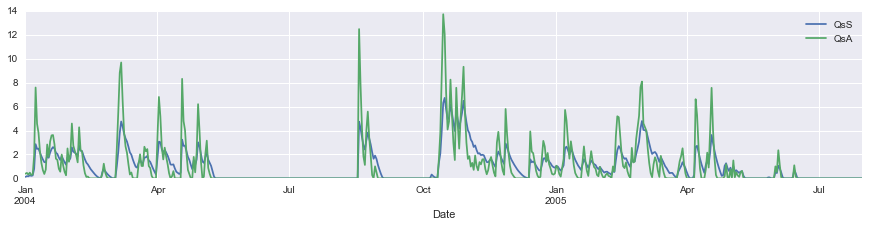

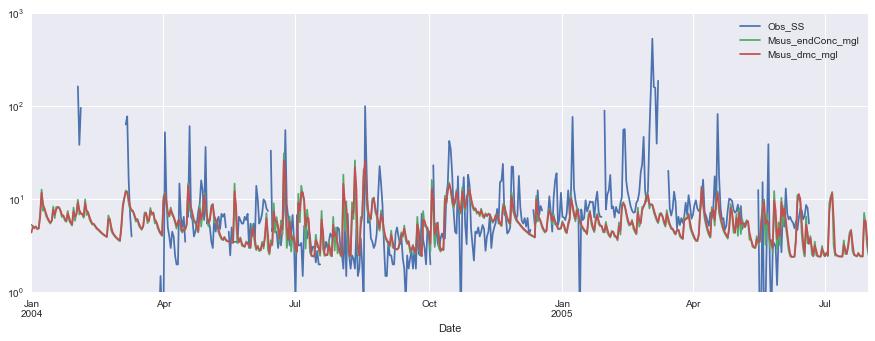

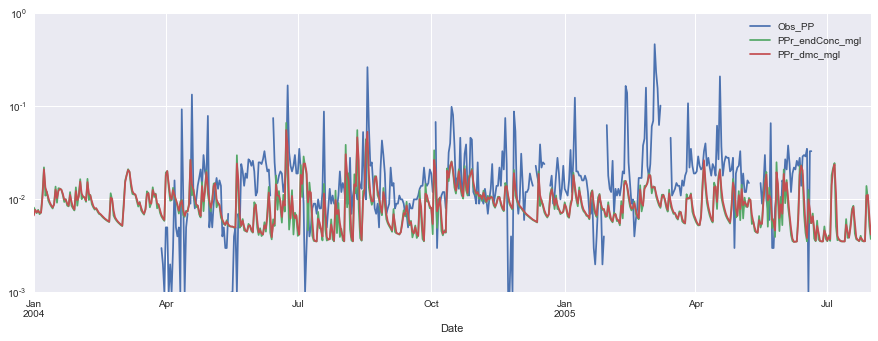

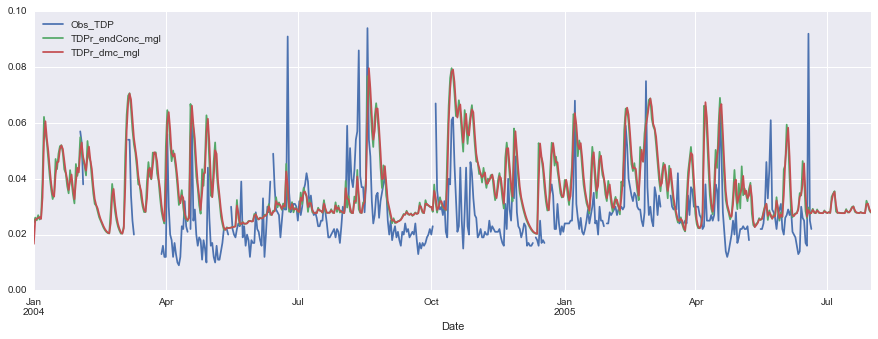

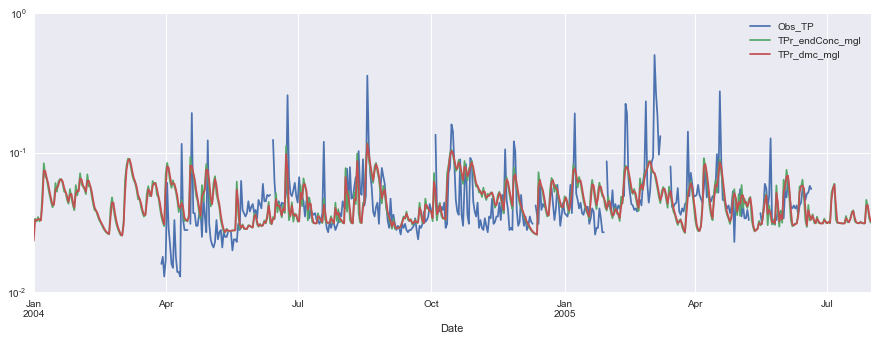

In [12]:
# EXAMINE OUTPUT

# Plot some timeseries

# Internal stuff
# fig3 = df[['VsA','VsS','QsA','TDPs_A_kgmm', 'Qg','Qr','TDPr_kgmm']].plot(subplots=True,figsize=(15, 10))
# fig3 = df[['Plabile_mg/kg','EPC0_A_mgl','TDPs_mgl']].plot(subplots=True,figsize=(15, 10))
# fig3 = df[['P_labile_A','P_labile_NC', 'EPC0_A_kgmm', 'EPC0_NC_kgmm']].plot(subplots=True,figsize=(15, 15))

# Discharge
# fig1 = df[['Obs_Q_cumecs', 'Sim_Q_cumecs']].plot(figsize=(15, 3))
fig1 = df[['QsS', 'QsA']].plot(figsize=(15, 3))
# df_logs = np.log(df)
# fig2 = df_logs[['Sim_Q_cumecs', 'Obs_Q_cumecs']].plot(alpha=0.5,figsize=(15, 3))

# Observed & simulated SS conc
fig4 = df[['Obs_SS', 'Msus_endConc_mgl', 'Msus_dmc_mgl']].plot(figsize=(15,5),logy=True)
fig4.set_ylim(1)
# plt.savefig(r'M:\Working\NewModel\ModelOutputs\sed1.png')

# Observed & simulated instream PP conc
fig6 = df[['Obs_PP', 'PPr_endConc_mgl', 'PPr_dmc_mgl']].plot(figsize=(15,5),logy=True)

# Observed & simulated instream TDP conc
fig5 = df[['Obs_TDP', 'TDPr_endConc_mgl', 'TDPr_dmc_mgl']].plot(figsize=(15,5),logy=False)

# Comparison between instantaneous conc at the end of the time step, and daily mean conc
# fig = df[['TDPr_endConc_mgl', 'TDPr_dmc_mgl']].plot(figsize=(15,10),color=['r','b'])

# Observed & simulated instream TP conc
fig7 = df[['Obs_TP', 'TPr_endConc_mgl', 'TPr_dmc_mgl']].plot(figsize=(15,5),logy=True)

# Print some stats
key_dict = {('Q','obs'):'Obs_Q_cumecs', ('Q','sim'):'Sim_Q_cumecs',
            ('SS','obs'):'Obs_SS', ('SS','sim'):'Msus_mgl',
            ('TDP','obs'):'Obs_TDP', ('TDP','sim'):'TDPr_mgl',
            ('PP','obs'):'Obs_PP', ('PP','sim'):'PPr_mgl',
            ('TP','obs'):'Obs_TP', ('TP','sim'):'TPr_mgl'}
# for var in ['SS','PP']:
#     obs = df[key_dict[(var,'obs')]]
#     sim = df[key_dict[(var,'sim')]]
#     temp_df = pd.concat([obs,sim],axis=1)
#     log_obs = np.log(obs)
#     log_sim = np.log(sim)

#     NSE = 1 - (np.sum((obs-sim)**2)/np.sum((obs-np.mean(obs))**2))
#     log_NSE = 1 - (np.sum((log_obs-log_sim)**2)/np.sum((log_obs-np.mean(log_obs))**2))
#     spearmans_r = temp_df.corr(method='spearman')
#     r2 = (temp_df.corr(method='pearson'))**2
#     print "%s NSE:" %var, NSE
#     print "%s NSE on logs" %var, log_NSE
#     print "%s Spearman's rank CC:" %var, spearmans_r[key_dict[(var,'obs')]].ix[1]
#     print "%s R2:" %var, r2[key_dict[(var,'obs')]].ix[1]

In [ ]:
df.columns

In [ ]:
# df.to_csv('C:\Users\lj40184\Desktop\WorkAtHome\ModelOutputs\df_2yrs_testingMeanFluxes2.csv')
p['A_catch']